In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'DAI-WETH-500'
NUMERAIRE_TOKEN = 0
MAX_DATE = '2022-01-28'
SAVE_FREQ = 'D'  # change to 'H' if you want hourly pool snapshots
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_DAILY_RETURNS = f'./saved-daily-returns/{POOL}.pickle'
SAVED_WEEKLY_RETURNS = f'./saved-weekly-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295895 entries, 0 to 295894
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   swap_time                       295895 non-null  datetime64[ns, UTC]
 1   tx_hash                         295895 non-null  string             
 2   token_0_amount                  295895 non-null  float64            
 3   token_1_amount                  295895 non-null  float64            
 4   pool_address                    295895 non-null  string             
 5   price_tick                      295895 non-null  int64              
 6   price_tick_adjusted             295895 non-null  float64            
 7   contract_address_token_0        295895 non-null  string             
 8   contract_name_token_0           295895 non-null  string             
 9   contract_ticker_symbol_token_0  295895 non-null  string             
 

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 19:26:20+00:00,0x1c7ebe833684f57b2051d9c069576c2c1242317f925a...,4748.768022,-1.828371,0x60594a405d53811d3bc4766596efd80fd545a270,-78628,0.000385,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 18:03:43+00:00
1,2022-01-29 19:23:48+00:00,0x3e61a82ff368228be45be3085b1971fb11a8db372717...,4754.024908,-1.832729,0x60594a405d53811d3bc4766596efd80fd545a270,-78615,0.000385,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 18:03:43+00:00
2,2022-01-29 19:18:34+00:00,0xd40313d828b59b281d9bf86914a688f3a2663239d9bf...,112780.832866,-44.174641,0x60594a405d53811d3bc4766596efd80fd545a270,-78602,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 18:03:43+00:00
3,2022-01-29 19:18:34+00:00,0x8128dacd2c44db0c743d6b966e4f4ca056c466d7d0aa...,-9645.787068,3.834978,0x60594a405d53811d3bc4766596efd80fd545a270,-78297,0.000398,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 18:03:43+00:00
4,2022-01-29 19:18:34+00:00,0x92830d60fa959f3f8318c170e75c73c70793da258ad9...,-112780.832866,44.103316,0x60594a405d53811d3bc4766596efd80fd545a270,-78324,0.000397,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 18:03:43+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        3464 non-null   datetime64[ns, UTC]
 1   tx_hash                         3464 non-null   string             
 2   token_0_amount                  3464 non-null   float64            
 3   token_1_amount                  3464 non-null   float64            
 4   pool_address                    3464 non-null   string             
 5   liquidity_event                 3464 non-null   string             
 6   price_tick_lower                3464 non-null   int64              
 7   price_tick_upper                3464 non-null   int64              
 8   price_tick_lower_adjusted       3464 non-null   float64            
 9   price_tick_upper_adjusted       3464 non-null   float64            
 10  contract_add

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-28 04:12:04+00:00,0x9aab388a72e2ba5e472c1001e7943721b479151feed1...,0.000000,0.000000,0x60594a405d53811d3bc4766596efd80fd545a270,REMOVE_LIQUIDITY,-81840,-75900,0.000279,5.056729e-04,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0xbeb730172e5f8cee9108b8dab3b1fa0069e45ecc,500,10,2021-05-05 18:03:43+00:00,-0.000000
1,2022-01-28 04:12:04+00:00,0x9aab388a72e2ba5e472c1001e7943721b479151feed1...,1783.619135,1.264468,0x60594a405d53811d3bc4766596efd80fd545a270,REMOVE_LIQUIDITY,-81840,-75900,0.000279,5.056729e-04,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0xbeb730172e5f8cee9108b8dab3b1fa0069e45ecc,500,10,2021-05-05 18:03:43+00:00,-359.264306
2,2022-01-27 15:39:18+00:00,0x35183b22b7cedfa01048ec8c6c6bb85d0f87beb58117...,0.000000,12.577052,0x60594a405d53811d3bc4766596efd80fd545a270,REMOVE_LIQUIDITY,-87000,-80070,0.000167,3.332560e-04,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0xf77c292a34b2251af2267799e129ae54b83c3d17,500,10,2021-05-05 18:03:43+00:00,-2352.750760
3,2022-01-27 13:59:39+00:00,0x531f2e6b673199bce5a7ade87dcdc0c5cc20b8f28724...,520.032478,0.209768,0x60594a405d53811d3bc4766596efd80fd545a270,REMOVE_LIQUIDITY,-887270,887270,0.000000,3.401887e+38,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x345bca32773cb4579150a58ce4039ba57dfae43b,500,10,2021-05-05 18:03:43+00:00,-10.444429
4,2022-01-27 10:18:58+00:00,0x384cc11db18a5ee8032273813665fa7662a460f3af12...,301.158031,0.104927,0x60594a405d53811d3bc4766596efd80fd545a270,REMOVE_LIQUIDITY,-79280,-76580,0.000361,4.724318e-04,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0xac4adaa309b579a889138810e33f32a3d78906e8,500,10,2021-05-05 18:03:43+00:00,-86.415291


In [6]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-05 18:03:43+00:00,0xf35783634dec2637b9aba3d1ab38025be8d1571276fe...,650.000000,0.034447,0x60594a405d53811d3bc4766596efd80fd545a270,ADD_LIQUIDITY,-81610,-80070,0.000286,0.000333,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x9d31e30003f253563ff108bc60b16fdf2c93abb5,500,10,2021-05-05 18:03:43+00:00,175.438663
1,2021-05-05 19:08:55+00:00,0x704e14e18f381a568d8a63fe12dd781c614e3a92698e...,12.780032,0.006507,0x60594a405d53811d3bc4766596efd80fd545a270,ADD_LIQUIDITY,-84120,-79730,0.000222,0.000345,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xb92c1c620f999db581057631c2f8e43c80d01c50,500,10,2021-05-05 18:03:43+00:00,2.891117
2,2021-05-05 20:59:29+00:00,0x504798d011af45284aacb173b0ad54c85921ea6d7fc0...,188.893079,0.066249,0x60594a405d53811d3bc4766596efd80fd545a270,ADD_LIQUIDITY,-84130,-79130,0.000222,0.000366,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xd7169d72187c58461085883727dbb2bdcea71295,500,10,2021-05-05 18:03:43+00:00,30.249618
3,2021-05-05 21:46:12+00:00,0x5c45d34da3c871c84d768553a683028fd361defe92e5...,0.000000,5.000000,0x60594a405d53811d3bc4766596efd80fd545a270,ADD_LIQUIDITY,-81750,-81610,0.000282,0.000286,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x5016cef7b054943cbd6e4432aa2063bc0bff6171,500,10,2021-05-05 18:03:43+00:00,42409.463515
4,2021-05-05 22:20:35+00:00,0xb67a9c69d5303668a8781a16d957e2bd175363265538...,3425.216423,0.392481,0x60594a405d53811d3bc4766596efd80fd545a270,ADD_LIQUIDITY,-81380,-81370,0.000292,0.000293,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x764172f0823089aa35739d7c837b6efb7effbc44,500,10,2021-05-05 18:03:43+00:00,163080.483027


In [7]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0xf35783634dec2637b9aba3d1ab38025be8d1571276fe58c2629aab2d015cfd70


In [8]:
# from https://etherscan.io/tx/0xf35783634dec2637b9aba3d1ab38025be8d1571276fe58c2629aab2d015cfd70#eventlog
liquidity_delta = amount_to_float('175438662754540782561', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (WETH/DAI): 2.923692113061e-04
Pool initial price (DAI/WETH): 3.420332789259e+03


In [9]:
sqrt_price_x96 = 1.354707084081889255546596745e+27
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 2.923692113061e-04
Price per Etherscan:      2.923692113059e-04


In [10]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,3463,0xf35783634dec2637b9aba3d1ab38025be8d1571276fe...,2021-05-05 18:03:43+00:00,ADD_LIQUIDITY
1,295894,0x2c0d1e818a140219b6a9984fe08ecc8109d3cdf56e65...,2021-05-05 18:09:08+00:00,SWAP
2,295893,0xd5aadb95c5d98a969fb537ae9075fbcf93b664633a18...,2021-05-05 18:43:18+00:00,SWAP
3,295892,0x51e4a49635139d66169a3339b6f297622dbaf2f83442...,2021-05-05 18:53:39+00:00,SWAP
4,3462,0x704e14e18f381a568d8a63fe12dd781c614e3a92698e...,2021-05-05 19:08:55+00:00,ADD_LIQUIDITY
...,...,...,...,...
298874,482,0x9ab7de3377a4be9918a80686e2a7683bcb39a61441ac...,2022-01-27 23:10:51+00:00,SWAP
298875,481,0xc9b741ca8a939bfa099f36c71ec448d45009e5391f1a...,2022-01-27 23:46:18+00:00,SWAP
298876,480,0xdd6afa2970873a4f6c2fd4bd475fdc6f1675fcf8578e...,2022-01-27 23:51:38+00:00,SWAP
298877,479,0x07bec5fddc0dc3125755694432eccdf056c9510b2ca4...,2022-01-27 23:53:59+00:00,SWAP


In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
TOKEN1_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [ ]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    save_freq=SAVE_FREQ,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

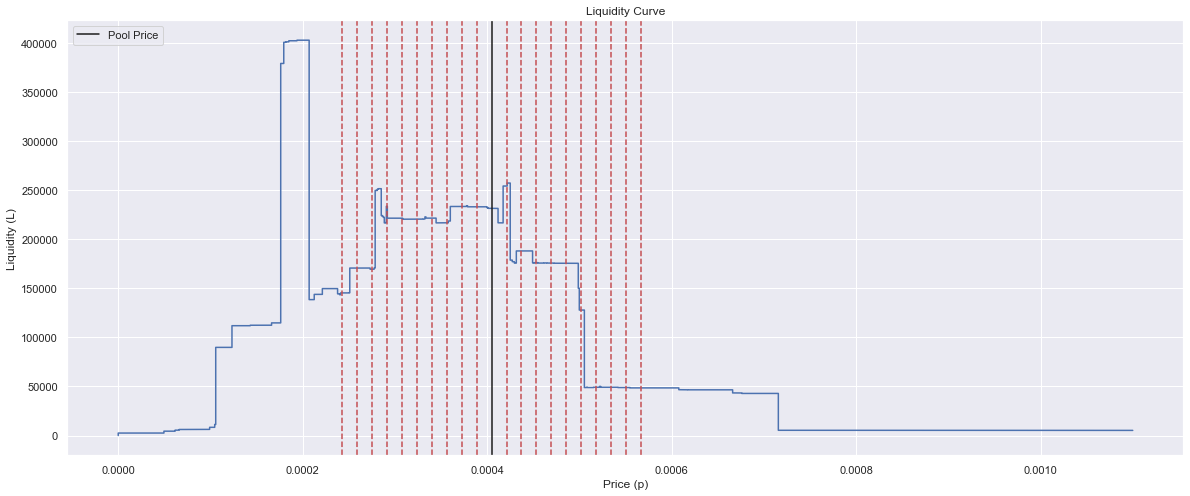

In [13]:
example_day = '2022-01-27 00:00:00'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 0.001), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

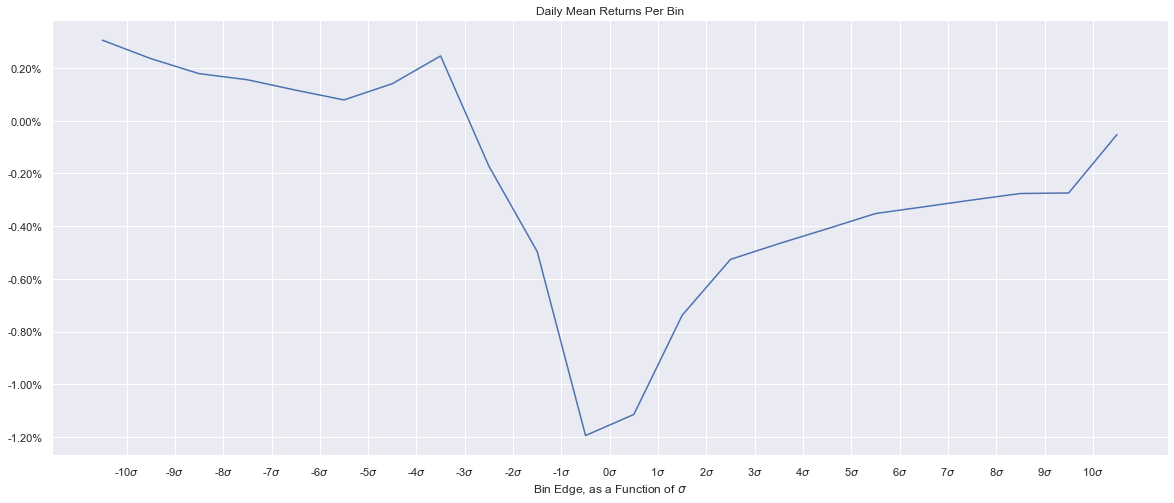

CPU times: user 1min 58s, sys: 4.08 s, total: 2min 2s
Wall time: 2min 3s


In [14]:
%%time
# daily returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='D',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_DAILY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

../uniswapv3_simulator/utils.py:428: RuntimeWarning: invalid value encountered in power
  return np.sum(cash_flows / (1 + irr[0]) ** time)


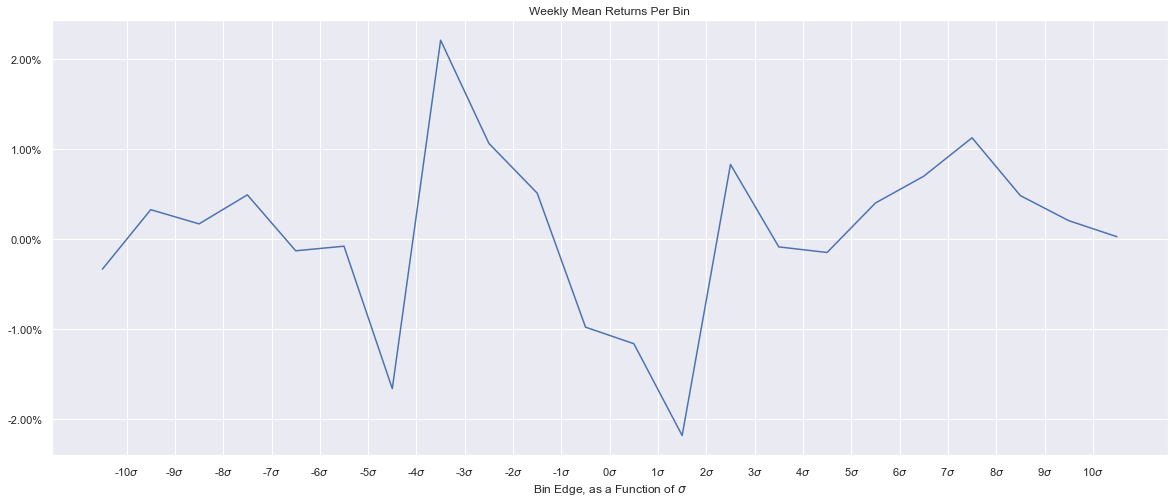

CPU times: user 1min 6s, sys: 2.54 s, total: 1min 9s
Wall time: 1min 9s


In [15]:
%%time
# weekly returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='W',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Weekly Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [16]:
# %%time
# # hourly returns
# all_returns = calc_all_returns_per_bin(
#     pool_snapshots, 
#     all_txn, 
#     liquidity, 
#     swaps,
#     freq='H',  # pandas frequency codes (can also include anchor)
#     sigma=0.005,  # reducing this for this test
#     numeraire_token=NUMERAIRE_TOKEN
# )
# # pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS) NOT SAVING THIS ONE FOR NOW!
   
# bin_returns = defaultdict(list)
# for day, irrs in all_returns.items():
#     for bin_pos, irr in irrs.items():
#         bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
#         bin_returns[bin_no].append(irr)
        
# fig, ax = plt.subplots(figsize=(20, 8))

# x_pos, x_labels, y = [], [], []
# for i in range(1, 23):
#     x_pos.append(i)
#     x_labels.append(f'{i - 11}$\sigma$')
#     y.append(np.mean(bin_returns[i]))
# ax.plot(x_pos, y)

# ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
# ax.set_title('Hourly Mean Returns Per Bin')
# ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

# plt.show()